[*********************100%***********************]  1 of 1 completed


Election years in the dataset: [2000, 2004, 2008, 2012, 2016, 2020, 2024]


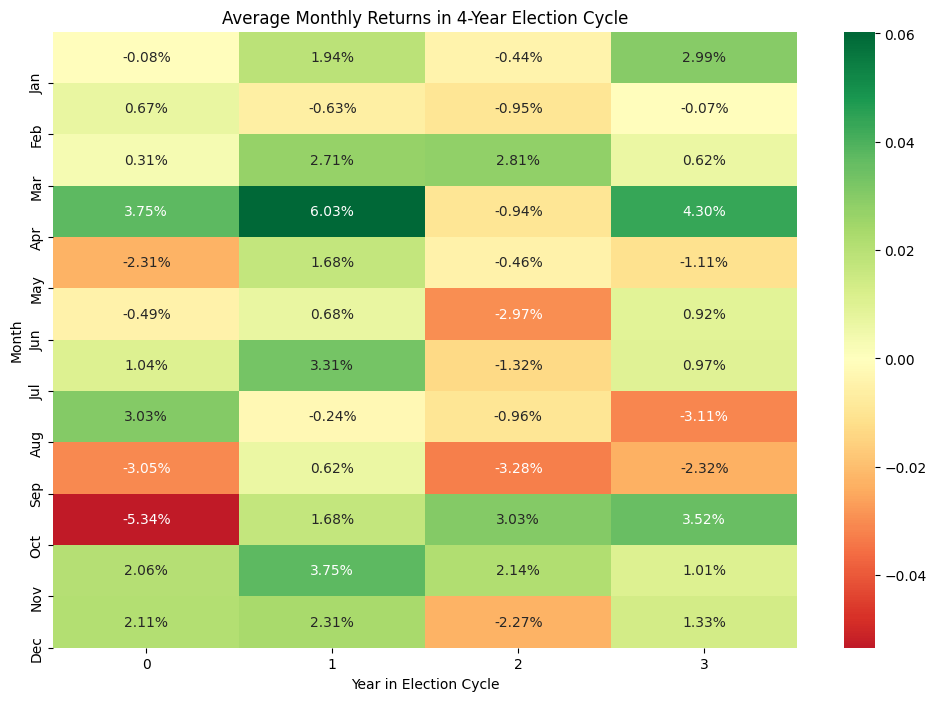

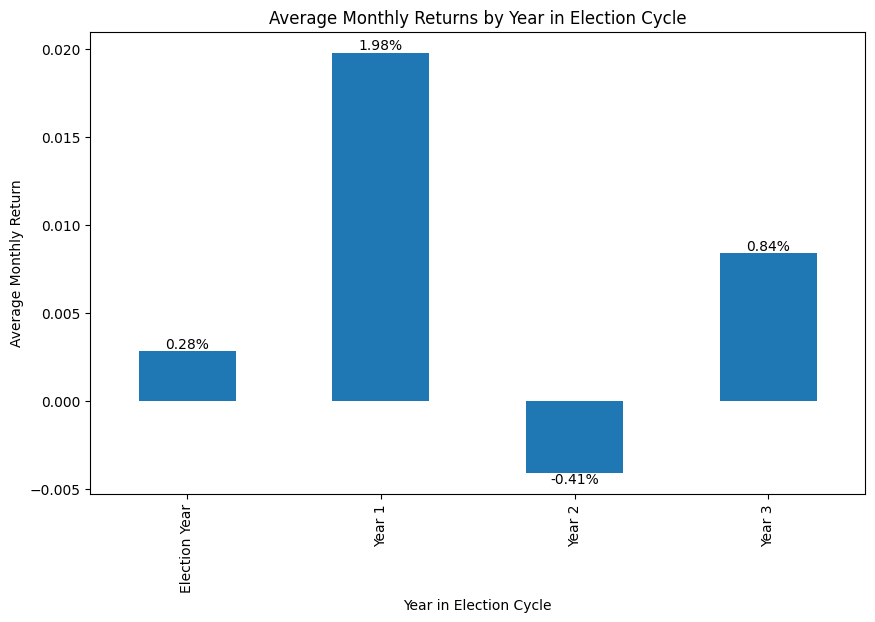

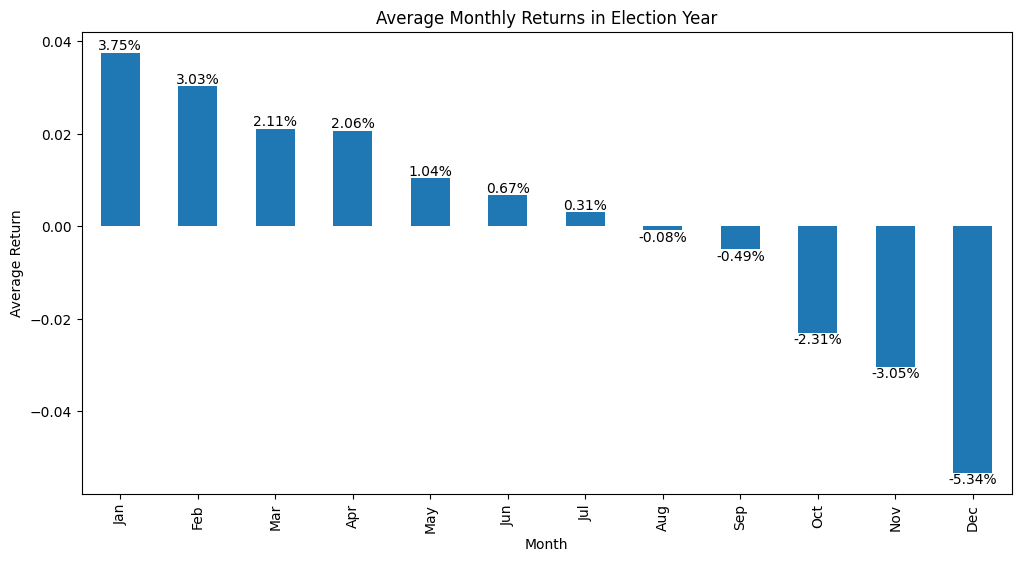

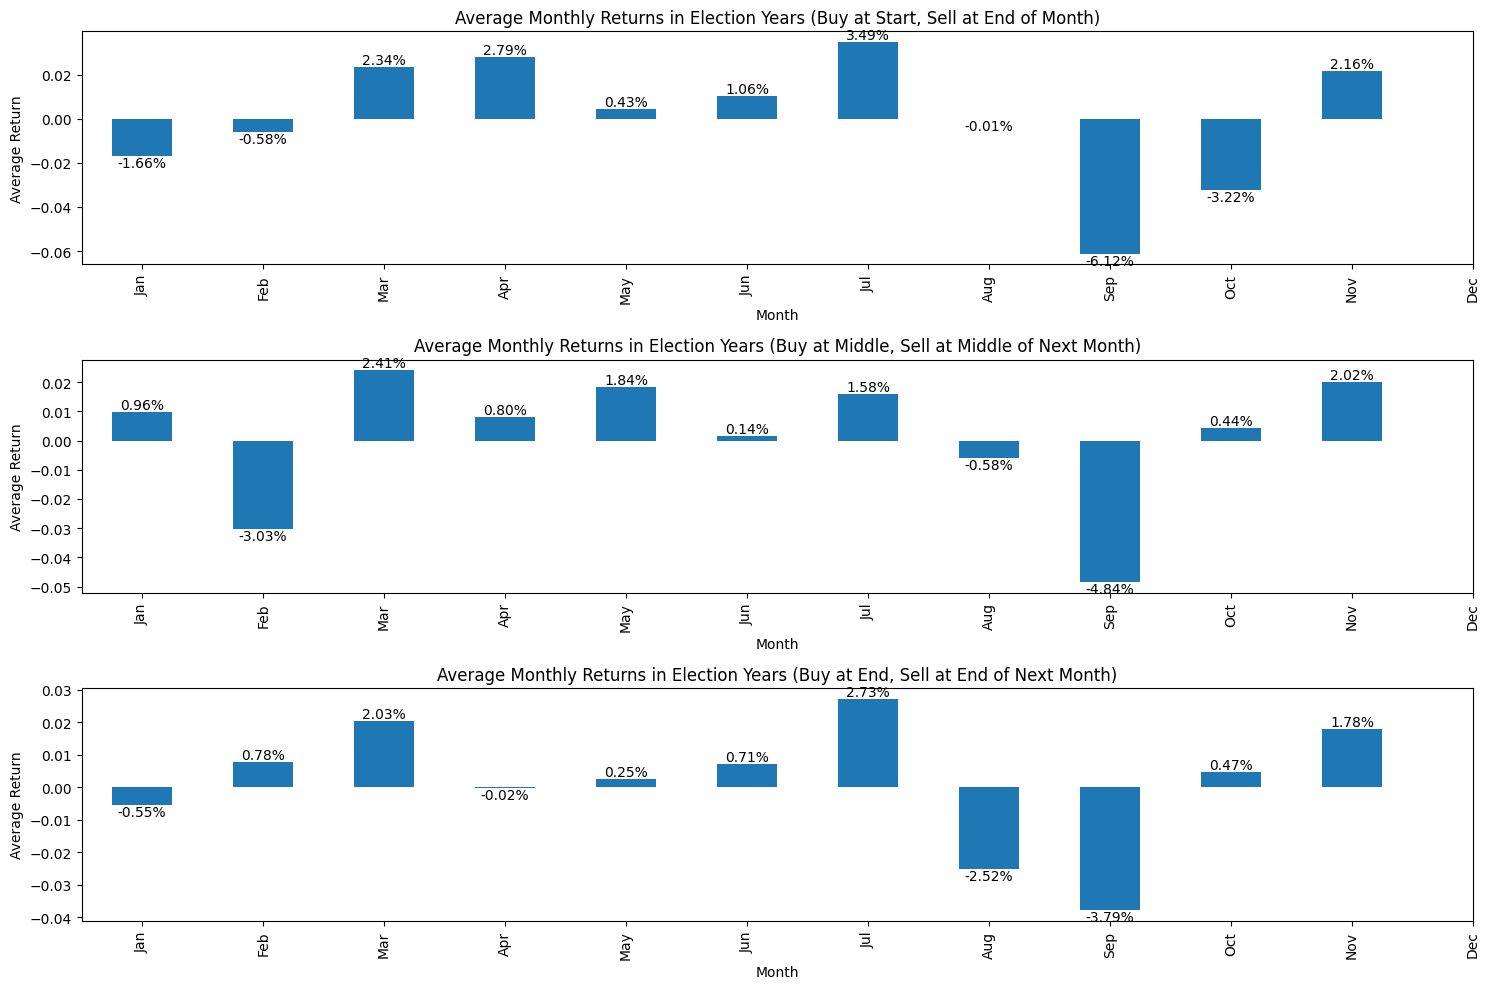

Election year monthly buy-and-sell analysis complete for all strategies.


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Download S&P 500 data (using ^GSPC as a proxy for the overall stock market)
ticker = "^GSPC"
data = yf.download(ticker, start="2000-01-01", end="2024-03-01")

# Create a function to determine the year in the election cycle
def election_year(date):
    year = date.year
    return (year - 2000) % 4  # 2000 was an election year, so we use it as a reference

# Add election cycle year to the dataframe
data['Election_Year'] = data.index.map(election_year)

# Print the election years
election_years = data[data['Election_Year'] == 0].index.year.unique()
print("Election years in the dataset:", election_years.tolist())

# Calculate monthly returns
data['Monthly_Return'] = data['Close'].resample('M').ffill().pct_change()

# Group by election cycle year and month, then calculate average returns
election_cycle_returns = data.groupby([data.index.month, 'Election_Year'])['Monthly_Return'].mean().unstack()

# Plot heatmap of returns by month and election cycle year
plt.figure(figsize=(12, 8))
sns.heatmap(election_cycle_returns, cmap='RdYlGn', center=0, annot=True, fmt='.2%')
plt.title('Average Monthly Returns in 4-Year Election Cycle')
plt.xlabel('Year in Election Cycle')
plt.ylabel('Month')
plt.yticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Calculate average returns for each year in the election cycle
yearly_returns = data.groupby('Election_Year')['Monthly_Return'].mean()

plt.figure(figsize=(10, 6))
yearly_returns.plot(kind='bar')
plt.title('Average Monthly Returns by Year in Election Cycle')
plt.xlabel('Year in Election Cycle')
plt.ylabel('Average Monthly Return')
plt.xticks(range(4), ['Election Year', 'Year 1', 'Year 2', 'Year 3'])
for i, v in enumerate(yearly_returns):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom' if v > 0 else 'top')
plt.show()

# Focus on the election year (Year 0)
election_year_returns = election_cycle_returns[0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
election_year_returns.plot(kind='bar')
plt.title('Average Monthly Returns in Election Year')
plt.xlabel('Month')
plt.ylabel('Average Return')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
for i, v in enumerate(election_year_returns):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom' if v > 0 else 'top')
plt.show()

# Function to analyze returns for different buying and selling strategies
def analyze_returns(data, buy_point, sell_point):
    election_year_data = data[data['Election_Year'] == 0]
    election_year_data['Month'] = election_year_data.index.month
    election_year_data['Year'] = election_year_data.index.year

    monthly_returns = []

    for year in election_year_data['Year'].unique():
        for month in range(1, 13):
            month_data = election_year_data[(election_year_data['Year'] == year) & (election_year_data['Month'] == month)]
            if not month_data.empty:
                if buy_point == 'start':
                    buy_price = month_data.iloc[0]['Open']
                elif buy_point == 'middle':
                    buy_price = month_data.iloc[len(month_data)//2]['Close']
                else:  # end
                    buy_price = month_data.iloc[-1]['Close']

                next_month = month + 1 if month < 12 else 1
                next_year = year if month < 12 else year + 1
                next_month_data = election_year_data[(election_year_data['Year'] == next_year) & (election_year_data['Month'] == next_month)]

                if not next_month_data.empty:
                    if sell_point == 'start':
                        sell_price = next_month_data.iloc[0]['Open']
                    elif sell_point == 'middle':
                        sell_price = next_month_data.iloc[len(next_month_data)//2]['Close']
                    else:  # end
                        sell_price = next_month_data.iloc[-1]['Close']

                    monthly_return = (sell_price - buy_price) / buy_price
                    monthly_returns.append({'Year': year, 'Month': month, 'Return': monthly_return})

    monthly_returns_df = pd.DataFrame(monthly_returns)
    average_monthly_returns = monthly_returns_df.groupby('Month')['Return'].mean()

    return average_monthly_returns

# Analyze different strategies
start_to_end = analyze_returns(data, 'start', 'end')
middle_to_middle = analyze_returns(data, 'middle', 'middle')
end_to_end = analyze_returns(data, 'end', 'end')

# Plot results
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
start_to_end.plot(kind='bar')
plt.title('Average Monthly Returns in Election Years (Buy at Start, Sell at End of Month)')
plt.xlabel('Month')
plt.ylabel('Average Return')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
for i, v in enumerate(start_to_end):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom' if v > 0 else 'top')

plt.subplot(3, 1, 2)
middle_to_middle.plot(kind='bar')
plt.title('Average Monthly Returns in Election Years (Buy at Middle, Sell at Middle of Next Month)')
plt.xlabel('Month')
plt.ylabel('Average Return')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
for i, v in enumerate(middle_to_middle):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom' if v > 0 else 'top')

plt.subplot(3, 1, 3)
end_to_end.plot(kind='bar')
plt.title('Average Monthly Returns in Election Years (Buy at End, Sell at End of Next Month)')
plt.xlabel('Month')
plt.ylabel('Average Return')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
for i, v in enumerate(end_to_end):
    plt.text(i, v, f'{v:.2%}', ha='center', va='bottom' if v > 0 else 'top')

plt.tight_layout()
plt.show()

print("Election year monthly buy-and-sell analysis complete for all strategies.")
